# MACHINE LEARNING WITH IRIS DATA: Part 1

This workbook is about:
<img src='./images/datascience-pipeline.png'/>

## LIBRARIES USED


* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

## The problem domain

We've been tasked to create a machine learning model that takes four measurements from the flowers (sepal length, sepal width, petal length, and petal width) and identifies the species based on those measurements alone.

<img src="images/petal_sepal.jpg" />

We've been given a [data set](iris-data.csv) from our field researchers to develop the demo, which only includes measurements for three types of *Iris* flowers:

### *Iris setosa*

<img src="images/iris_setosa.jpg" />

### *Iris versicolor*
<img src="images/iris_versicolor.jpg" />

### *Iris virginica*
<img src="images/iris_virginica.jpg" />

The four measurements we're using currently come from hand-measurements by the field researchers, but they will be automatically measured by an image processing model in the future.

**Note:** The data set I am working with is the famous [*Iris* data set](https://archive.ics.uci.edu/ml/datasets/Iris) — included with this notebook.

## STEP 1: BRAINSTROMING ON FEW OF THE QUESTION

>Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

We're trying to classify the species (i.e., class) of the flower based on four measurements that we're provided: sepal length, sepal width, petal length, and petal width.

>Did you define the metric for success?

(https://en.wikipedia.org/wiki/Accuracy_and_precision) — the fraction of correctly classified flowers — to quantify how well our model is performing. Our head of data has told us that we should achieve at least 90% accuracy.

>Did you understand the context for the question and the scientific or business application?

We're building part of a data analysis pipeline for a smartphone app that will be able to classify the species of flowers from pictures taken on the smartphone. In the future, this pipeline will be connected to another pipeline that automatically measures from pictures the traits we're using to perform this classification.

>Did you record the experimental design?

We were told that the field researchers are hand-measuring 50 randomly-sampled flowers of each species using a standardized methodology. The field researchers take pictures of each flower they sample from pre-defined angles so the measurements and species can be confirmed by the other field researchers at a later point. At the end of each day, the data is compiled and stored on a private company's Hadoop or GitHub repository.

>Did you consider whether the question could be answered with the available data?

The data set we currently have is only for three types of *Iris* flowers. The model built off of this data set will only work for those *Iris* flowers, so we will need more data to create a general flower classifier.


## STEP 2: CHECKINGTHE DATA

In [1]:
import pandas as pd

iris_data = pd.read_csv('./data/iris-data.csv')
iris_data.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


We're in luck! The data seems to be in a usable format.

**One of the first things we should look for is missing data.** The spreadsheet has 'NA'when they were missing a measurement.

We can tell pandas to automatically identify missing values if it knows our missing value marker.

In [3]:
iris_data = pd.read_csv('./data/iris-data.csv', na_values=['NA'])

In [4]:
iris_data.shape

(150, 5)

In [5]:
iris_data.describe()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
count,150.000000,150.000000,150.000000,145.000000
mean,5.644627,3.054667,3.758667,1.236552
std,1.312781,0.433123,1.764420,0.755058
min,0.055000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.400000
50%,5.700000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

Next, let's create a **scatterplot matrix**. They make for an efficient tool to look for errors in our data.

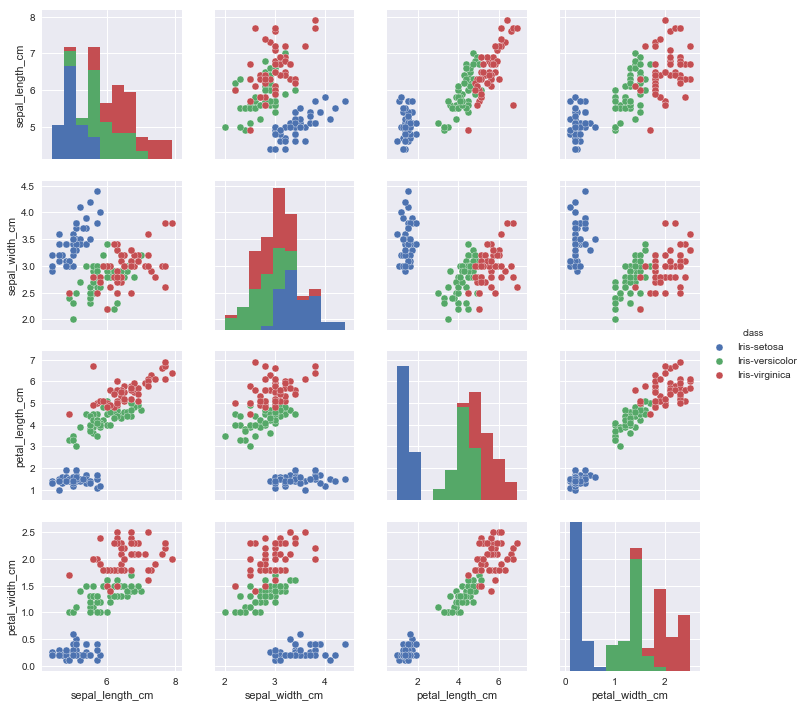

In [26]:
# We have to temporarily drop the rows with 'NA' values
# because the Seaborn plotting function does not know
# what to do with them
sb.pairplot(iris_data.dropna(), hue='class')

From the scatterplot matrix, we can already see some issues with the data set:

1. There are five classes when there should only be three, meaning there were some coding errors.

2. There are some clear outliers in the measurements that may be erroneous: one `sepal_width_cm` entry for `Iris-setosa` falls well outside its normal range, and several `sepal_length_cm` entries for `Iris-versicolor` are near-zero for some reason.

3. We had to drop those rows with missing values.

In all of these cases, we need to figure out what to do with the erroneous data. Which takes us to the next step...

## STEP 3: TIDYING THE DATA

Now that we've identified several errors in the data set, we need to fix them before we proceed with the analysis.

Let's walk through the issues one-by-one.

>There are five classes when there should only be three, meaning there were some coding errors.

After talking with the field researchers, it sounds like one of them forgot to add `Iris-` before their `Iris-versicolor` entries. The other extraneous class, `Iris-setossa`, was simply a typo that they forgot to fix.

Let's use the DataFrame to fix these errors.

In [27]:
iris_data.loc[iris_data['class'] == 'versicolor', 'class'] = 'Iris-versicolor'
iris_data.loc[iris_data['class'] == 'Iris-setossa', 'class'] = 'Iris-setosa'

iris_data['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Now we only have three class types.

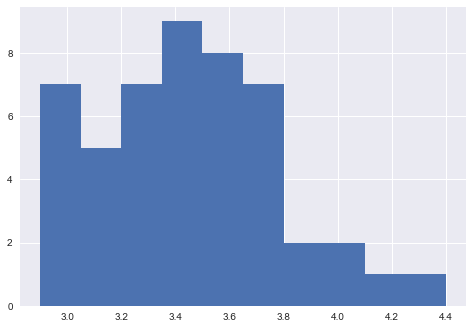

In [28]:
# This line drops any 'Iris-setosa' rows with a separal width less than 2.5 cm
iris_data = iris_data.loc[(iris_data['class'] != 'Iris-setosa') | (iris_data['sepal_width_cm'] >= 2.5)]
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()

Excellent! Now all of our `Iris-setosa` rows have a sepal width greater than 2.5.

The next data issue to address is the several near-zero sepal lengths for the `Iris-versicolor` rows. Let's take a look at those rows.

In [29]:
iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0)]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class


How about that? All of these near-zero `sepal_length_cm` entries seem to be off by two orders of magnitude, as if they had been recorded in meters instead of centimeters.

After some brief correspondence with the field researchers, we find that one of them forgot to convert those measurements to centimeters. Let's do that for them.

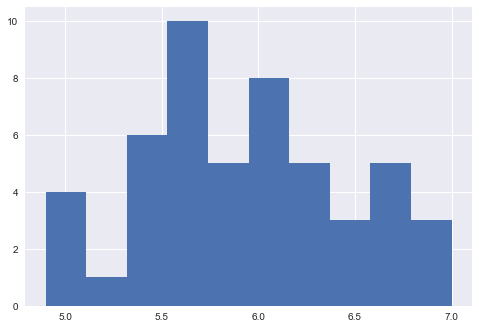

In [30]:
iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0),
              'sepal_length_cm'] *= 100.0

iris_data.loc[iris_data['class'] == 'Iris-versicolor', 'sepal_length_cm'].hist()

Good thing we fixed those outliers. They could've really thrown our analysis off.

>We had to drop those rows with missing values.

Let's take a look at the rows with missing values:

In [31]:
iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class


It's not ideal that we had to drop those rows, especially considering they're all `Iris-setosa` entries. Since it seems like the missing data is systematic — all of the missing values are in the same column for the same *Iris* type — this error could potentially bias our analysis.

One way to deal with missing data is **mean imputation**: If we know that the values for a measurement fall in a certain range, we can fill in empty values with the average of that measurement.

Let's see if we can do that here.

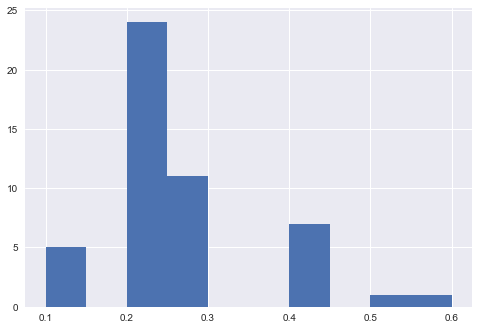

In [32]:
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].hist()

Most of the petal widths for `Iris-setosa` fall within the 0.2-0.3 range, so let's fill in these entries with the average measured petal width.

In [33]:
average_petal_width = iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].mean()

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'].isnull()),
              'petal_width_cm'] = average_petal_width

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'] == average_petal_width)]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class


In [34]:
iris_data.petal_width_cm.isnull()

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
120    False
121    False
122    False
123    False
124    False
125    False
126    False
127    False
128    False
129    False
130    False
131    False
132    False
133    False
134    False
135    False
136    False
137    False
138    False
139    False
140    False
141    False
142    False
143    False
144    False
145    False
146    False
147    False
148    False
149    False
Name: petal_width_cm, Length: 149, dtype: bool

In [35]:
iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class


Now we've recovered those rows and no longer have missing data in our data set.

Saving the tidied data file *as a separate file* and work directly with that data file from now on.

In [36]:
iris_data.to_csv('./data/iris-data-clean.csv', index=False)

iris_data_clean = pd.read_csv('./data/iris-data-clean.csv')

let's take a look at the scatterplot matrix now that we've tidied the data.

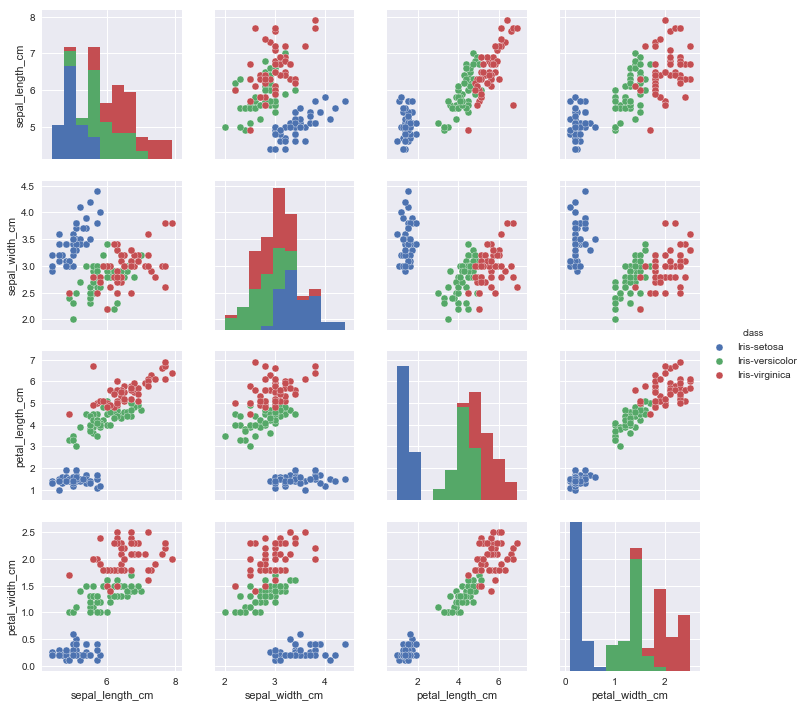

In [37]:
sb.pairplot(iris_data_clean, hue='class')

We purposely inserted numerous errors into this data set to demonstrate some of the many possible scenarios you may face while tidying your data.

## STEP 4: TESTING OUR DATA

Let's test a few things that we know about our data set now.

In [40]:
# We know that we should only have three classes
assert len(iris_data_clean['class'].unique()) == 3

In [41]:
# We know that sepal lengths for 'Iris-versicolor' should never be below 2.5 cm
assert iris_data_clean.loc[iris_data_clean['class'] == 'Iris-versicolor', 'sepal_length_cm'].min() >= 2.5

In [42]:
# We know that our data set should have no missing measurements
assert len(iris_data_clean.loc[(iris_data_clean['sepal_length_cm'].isnull()) |
                               (iris_data_clean['sepal_width_cm'].isnull()) |
                               (iris_data_clean['petal_length_cm'].isnull()) |
                               (iris_data_clean['petal_width_cm'].isnull())]) == 0

If any of these expectations are violated, then our analysis immediately stops and we have to return to the tidying stage.

## STEP 5: EXPLORATORY ANALYSIS
Let's return to that scatterplot matrix that we used earlier.

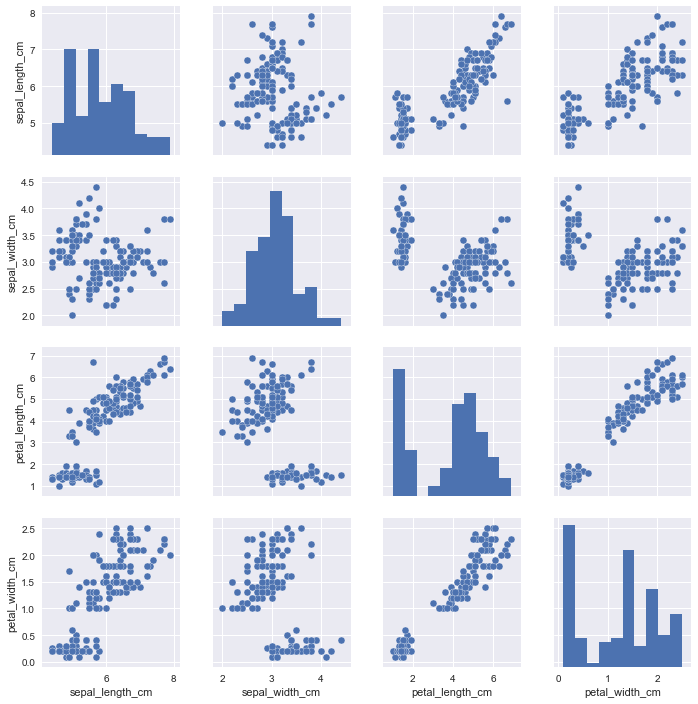

In [43]:
sb.pairplot(iris_data_clean)

Our data is normally distributed for the most part, which is great news if we plan on using any modeling methods that assume the data is normally distributed.

There's something strange going with the petal measurements. Maybe it's something to do with the different `Iris` types. Let's color code the data by the class again to see if that clears things up.

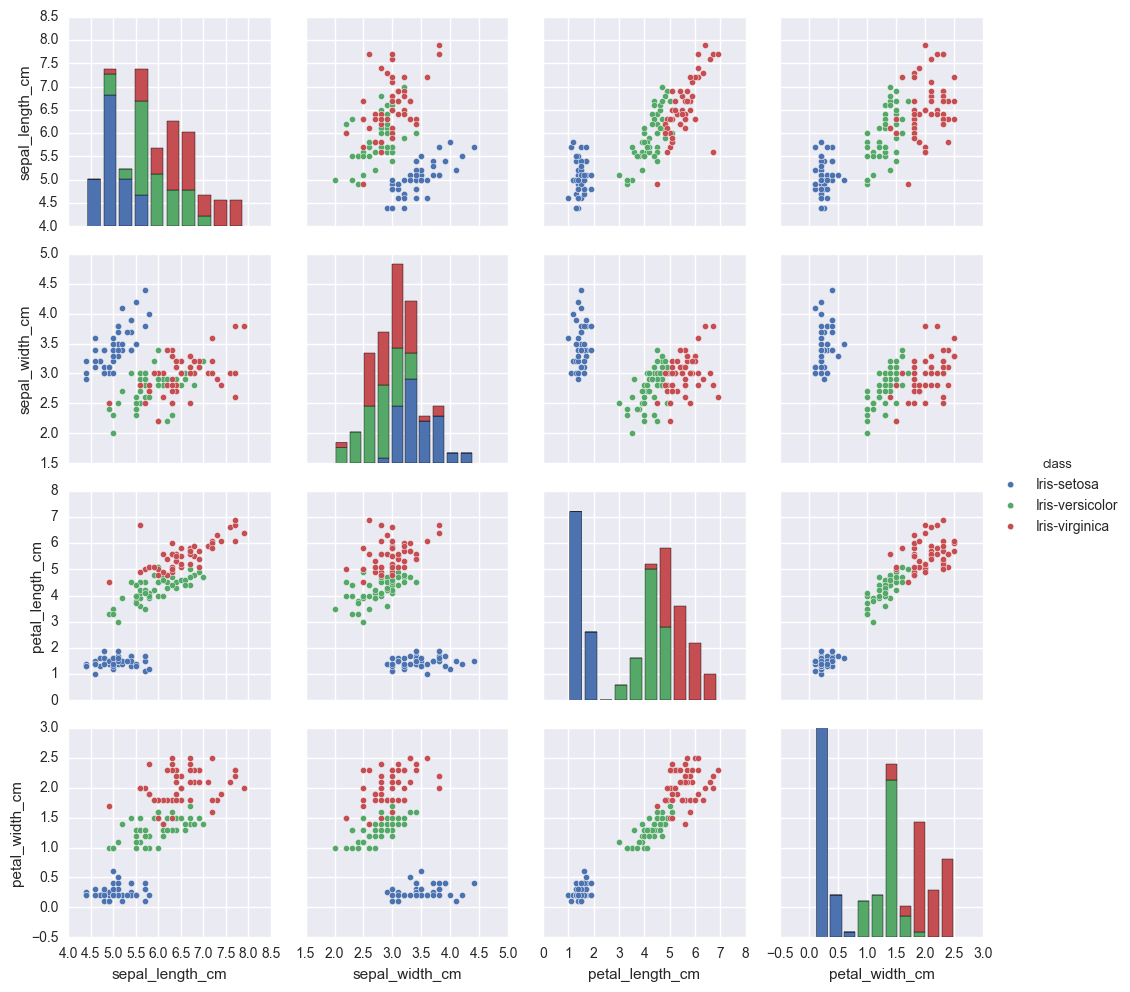

In [26]:
sb.pairplot(iris_data_clean, hue='class')

Sure enough, the strange distribution of the petal measurements exist because of the different species. This is actually great news for our classification task since it means that the petal measurements will make it easy to distinguish between `Iris-setosa` and the other `Iris` types.

Distinguishing `Iris-versicolor` and `Iris-virginica` will prove more difficult given how much their measurements overlap.

There are also correlations between petal length and petal width, as well as sepal length and sepal width. The field biologists assure us that this is to be expected: Longer flower petals also tend to be wider, and the same applies for sepals.

Let's get to modeling.

## STEP 6: CLASSIFICATION

Note that once we split the data into a training and testing set, we should treat the testing set like it no longer exists.

Other steps that are part of this section include:

1. Model Selection (Decision Tree Model already selected)
2. Model Evaluation  
3. Cross-validation
4. Parameter Tuning
5. Feature Selection using Random Forests 

In [27]:
iris_data_clean = pd.read_csv('./data/iris-data-clean.csv')

# We're using all four measurements as inputs
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
X = iris_data_clean[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

# Similarly, we can extract the classes
y = iris_data_clean['class'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_classes[5]

# Here's what a subset of our inputs looks like:
X[:5]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

Now our data is ready to be split.

In [28]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

In [29]:
X_train.shape, X_test.shape

((111L, 4L), (38L, 4L))

With our data split, we can start fitting models to our data. Our head of data is all about decision tree classifiers, so let's start with one of those.

<img src="iris_dtc.png" />

Notice how the classifier asks Yes/No questions about the data — whether a certain feature is <= 1.75, for example — so it can differentiate the records. This is the essence of every decision tree.

The nice part about decision tree classifiers is that they are **scale-invariant**, i.e., the scale of the features does not affect their performance, unlike many Machine Learning models. In other words, it doesn't matter if our features range from 0 to 1 or 0 to 1,000; decision tree classifiers will work with them just the same.

There are several [parameters](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) that we can tune for decision tree classifiers, but for now let's use a basic decision tree classifier.

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(X_train, y_train)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(X_test, y_test)

0.97368421052631582

In [32]:
y_pred = decision_tree_classifier.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.94736842105263153

Our model achieves 97% classification accuracy without much effort.

However, there's a catch: Depending on how our training and testing set was sampled, our model can achieve anywhere from 80% to 100% accuracy:

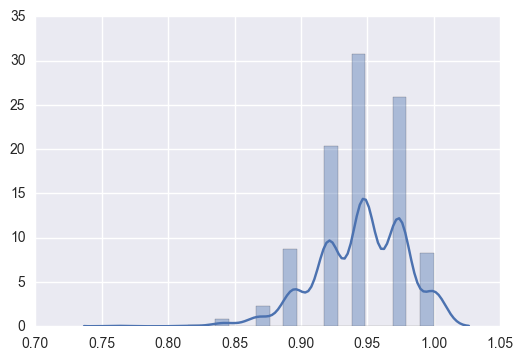

In [31]:
model_accuracies = []

for repetition in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(X_train, y_train)
    classifier_accuracy = decision_tree_classifier.score(X_test, y_test)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)

It's obviously a problem that our model performs quite differently depending on the subset of the data it's trained on. This phenomenon is known as **overfitting**: The model is learning to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before.

### CROSS-VALIDATION

[[ go back to the top ]](#Table-of-contents)

This problem is the main reason that most data scientists perform ***k*-fold cross-validation** on their models: Split the original data set into *k* subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated *k* times such that each subset is used as the testing set exactly once.

10-fold cross-validation is the most common choice, so let's use that here. Performing 5-fold cross-validation on our data set looks something like this:

<img src='./images/k-fold.jpg' />

(each square is an entry in our data set)

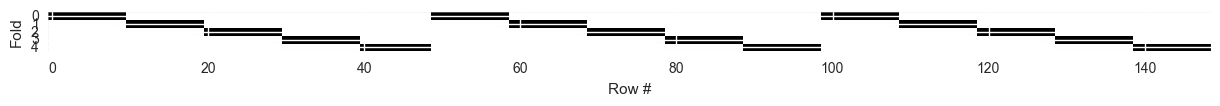

In [35]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

def plot_cv(cv, n_samples):
    masks = []
    for train, test in cv:
        mask = np.zeros(n_samples, dtype=bool)
        mask[test] = 1
        masks.append(mask)
        
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(y, n_folds=5), len(y))

You'll notice that we used **Stratified *k*-fold cross-validation** in the code above. Stratified *k*-fold keeps the class proportions the same across all of the folds, which is vital for maintaining a representative subset of our data set. (e.g., so we don't have 100% `Iris setosa` entries in one of the folds.)

We can perform 5-fold cross-validation on our model with the following code:

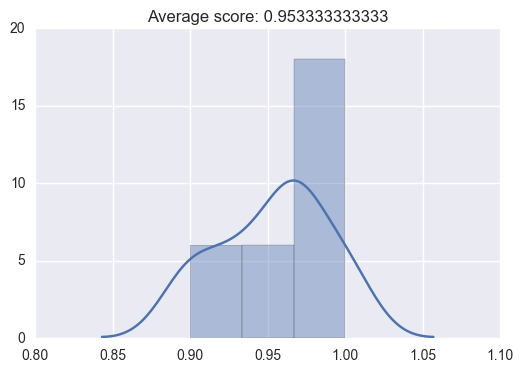

In [36]:
from sklearn.cross_validation import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=5)
sb.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

Now we have a much more consistent rating of our classifier's general classification accuracy.

### PARAMETER TUNING

[[ go back to the top ]](#Table-of-contents)

Every Machine Learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

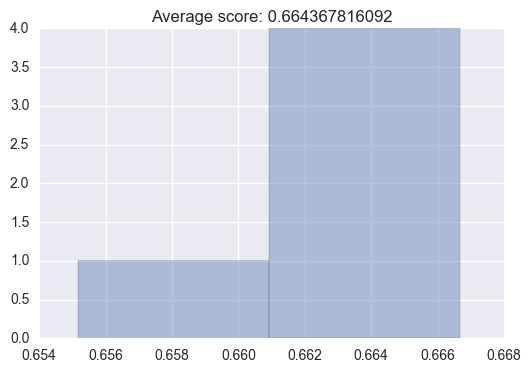

In [38]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1) #dept 1 is not a good that means

cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=5)
sb.distplot(cv_scores, kde=False)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

Tthe classification accuracy falls tremendously.

Therefore, we need to find a systematic method to discover the best parameters for our model and data set.

The most common method for model parameter tuning is **Grid Search**. The idea behind Grid Search is simple: explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier. We'll stick to only two parameters for now, but it's possible to simultaneously explore dozens of parameters if we want.

In [40]:
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [49]:
from sklearn.grid_search import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(y, n_folds=5)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.96644295302
Best parameters: {'max_features': 4, 'max_depth': 5}


Now let's visualize the grid search to see how the parameters interact.

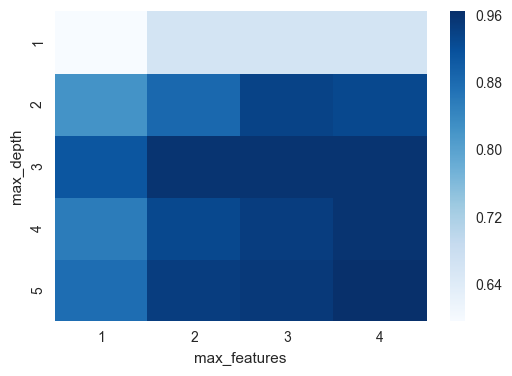

In [50]:
grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')

Now we have a better sense of the parameter space: We know that we need a `max_depth` of at least 2 to allow the decision tree to make more than a one-off decision.

`max_features` doesn't really seem to make a big difference here as long as we have 2 of them, which makes sense since our data set has only 4 features and is relatively easy to classify. (Remember, one of our data set's classes was easily separable from the rest based on a single feature.)

Let's go ahead and use a broad grid search to find the best settings for a handful of parameters.

In [53]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(y, n_folds=5)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.973154362416
Best parameters: {'max_features': 4, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 3}


Now we can take the best classifier from the Grid Search and use that:

In [54]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=4, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

We can even visualize the decision tree with [GraphViz](http://www.graphviz.org/) to see how it's making the classifications:

In [55]:
import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('iris_dtc.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

<img src="iris_dtc.png" />

(This classifier may look familiar from earlier in the notebook.)

Alright! We finally have our demo classifier. Let's create some visuals of its performance so we have something to show our head of data.

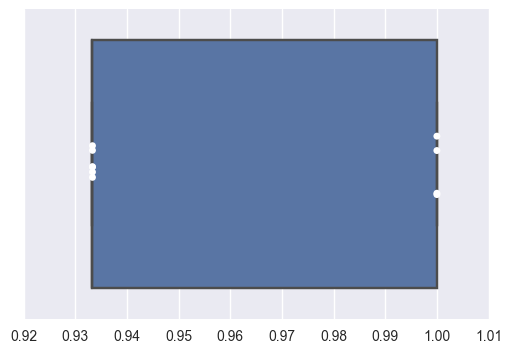

In [56]:
rf_scores = cross_val_score(decision_tree_classifier, X, y, cv=10)

sb.boxplot(rf_scores)
sb.stripplot(rf_scores, jitter=True, color='white')

Hmmm... that's a little boring by itself though. How about we compare another classifier to see how they perform?

We already know from previous projects that Random Forest classifiers usually work better than individual decision trees. A common problem that decision trees face is that they're prone to overfitting: They complexify to the point that they classify the training set near-perfectly, but fail to generalize to data they have not seen before.

**Random Forest classifiers** work around that limitation by creating a whole bunch of decision trees (hence "forest") — each trained on random subsets of training samples (drawn with replacement) and features (drawn without replacement) — and have the decision trees work together to make a more accurate classification.

Let that be a lesson for us: **Even in Machine Learning, we get better results when we work together!**

Let's see if a Random Forest classifier works better here.

The great part about scikit-learn is that the training, testing, parameter tuning, etc. process is the same for all models, so we only need to plug in the new classifier.

In [57]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [5, 10, 25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4],
                  'warm_start': [True, False]}

cross_validation = StratifiedKFold(y, n_folds=5)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.96644295302
Best parameters: {'max_features': 2, 'n_estimators': 25, 'criterion': 'gini', 'warm_start': True}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

Now we can compare their performance:

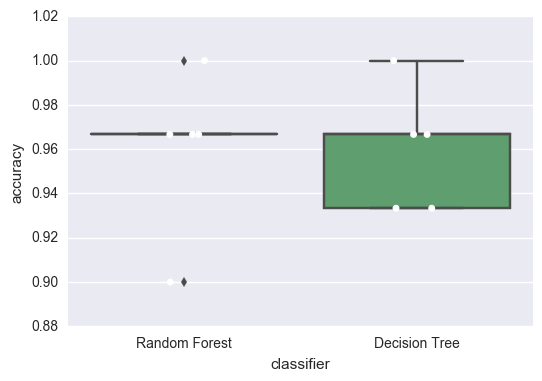

In [58]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, X, y, cv=5),
                       'classifier': ['Random Forest'] * 5})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, X, y, cv=5),
                      'classifier': ['Decision Tree'] * 5})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='white')

How about that? They both seem to perform about the same on this data set. This is probably because of the limitations of our data set: We have only 4 features to make the classification, and Random Forest classifiers excel when there's hundreds of possible features to look at. In other words, there wasn't much room for improvement with this data set.

Finally, let's extract the core of our work from Steps 1-5 and turn it into a single pipeline.

[ 4.9  3.1  1.5  0.1]	-->	Iris-setosa	(Actual: Iris-setosa)
[ 6.   2.9  4.5  1.5]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[ 6.1  2.9  4.7  1.4]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[ 5.5  4.2  1.4  0.2]	-->	Iris-setosa	(Actual: Iris-setosa)
[ 7.4  2.8  6.1  1.9]	-->	Iris-virginica	(Actual: Iris-virginica)
[ 5.   3.5  1.3  0.3]	-->	Iris-setosa	(Actual: Iris-setosa)
[ 6.8  3.2  5.9  2.3]	-->	Iris-virginica	(Actual: Iris-virginica)
[ 6.9  3.2  5.7  2.3]	-->	Iris-virginica	(Actual: Iris-virginica)
[ 5.4  3.4  1.5  0.4]	-->	Iris-setosa	(Actual: Iris-setosa)
[ 6.1  3.   4.6  1.4]	-->	Iris-versicolor	(Actual: Iris-versicolor)


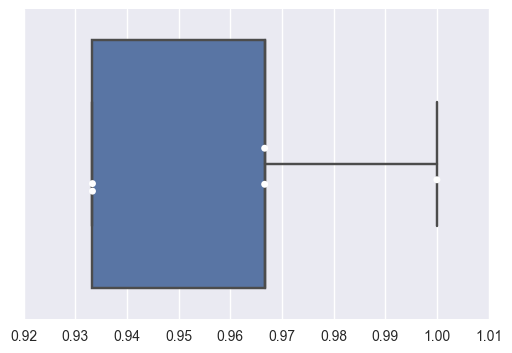

In [59]:
%matplotlib inline
import pandas as pd
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

# We can jump directly to working with the clean data because we saved our cleaned data set
iris_data_clean = pd.read_csv('./data/iris-data-clean.csv')

# Testing our data: Our analysis will stop here if any of these assertions are wrong

# We know that we should only have three classes
assert len(iris_data_clean['class'].unique()) == 3

# We know that sepal lengths for 'Iris-versicolor' should never be below 2.5 cm
assert iris_data_clean.loc[iris_data_clean['class'] == 'Iris-versicolor', 'sepal_length_cm'].min() >= 2.5

# We know that our data set should have no missing measurements
assert len(iris_data_clean.loc[(iris_data_clean['sepal_length_cm'].isnull()) |
                               (iris_data_clean['sepal_width_cm'].isnull()) |
                               (iris_data_clean['petal_length_cm'].isnull()) |
                               (iris_data_clean['petal_width_cm'].isnull())]) == 0

X = iris_data_clean[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

y = iris_data_clean['class'].values

# This is the classifier that came out of Grid Search
random_forest_classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                max_depth=None, max_features=3, max_leaf_nodes=None,
                                min_samples_leaf=1, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
                                oob_score=False, random_state=None, verbose=0, warm_start=True)

# All that's left to do now is plot the cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, X, y, cv=5)
sb.boxplot(rf_classifier_scores)
sb.stripplot(rf_classifier_scores, jitter=True, color='white')

# ...and show some of the predictions from the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

random_forest_classifier.fit(X_train, y_train)

for input_features, prediction, actual in zip(X_test[:10],
                                              random_forest_classifier.predict(X_test[:10]),
                                              y_test[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))

There we have it: We have a complete and reproducible Machine Learning pipeline to demo to our head of data. We've met the success criteria that we set from the beginning (>90% accuracy), and our pipeline is flexible enough to handle new inputs or flowers when that data set is ready. Not bad for our first week on the job!